# Price Prediction Model Part 3.1: Ensemble

We have found that classification models are slightly more accurate than the other models that we tested. In this notebook, we explore the best way to combine models using different numbers of classes.

TLDR
Using the same MSELoss function as when testing other models, we get a loss of about 0.95. This is better but still not as good as one would hope.

Here's a summary of the models that we plan to use.  

model | no. of classes |epochs| crit | optim | sched | train loss | train acc | test loss | test acc | MESLoss (see below) | saved  
--- | --- | --- | --- |--- |--- |--- | --- | ---| --- | --- | ---   
resnet34, fc=1 linear | 2 |10 | CrossEntropy | SGD, lr=0.001, m=0.9, wd=0.2 | StepLR, ss=3, g=0.1| 0.10| 0.99| 0.024| 0.62 | | yes
resnet34, fc=1 linear | 4 |10 | CrossEntropy | SGD, lr=0.001, m=0.9, wd=0.2 | StepLR, ss=3, g=0.1| 0.21| 0.99| 0.045| 0.40| | yes
resnet18, fc=1 linear | 8 |10 | CrossEntropy | SGD, lr=0.001, m=0.9, wd=0.2 | StepLR, ss=3, g=0.1| 1.08| 0.85| 0.0632| 0.26| | yes
resnet18, fc=1 linear | 16 |10 | CrossEntropy | SGD, lr=0.001, m=0.9, wd=0.2 | StepLR, ss=3, g=0.1| 1.72| 0.78| 0.085| 0.16| | yes
resnet18, fc=1 linear | 30 |10 | CrossEntropy | SGD, lr=0.001, m=0.9, wd=0.2 | StepLR, ss=3, g=0.1| 2.45 | 0.66 | 0.1044 | 0.118 |  | yes
resnet18, fc=1 linear | 50 |10| CrossEntropy | SGD, lr=0.001, m=0.9, wd=0.2 | StepLR, ss=3, g=0.1| 3.0068| 0.5889| 0.1213| 0.0911|  | yes
resnet34, fc=1 linear | 75 |10| CrossEntropy | SGD, lr=0.001, m=0.9, wd=0.2 | StepLR, ss=3, g=0.1| 3.06| 0.6732| 0.1333| 0.0922|  | yes
resnet34, fc=1 linear | 100 |10| CrossEntropy | SGD, lr=0.001, m=0.9 | StepLR, ss=3, g=0.1| 2.46| 0.79| 0.142| 0.088| 1.0029 | yes


In [12]:
import torch, torchvision, torch.nn as nn, torch.optim as optim, torch.nn.functional as F
import torchvision.transforms as transforms, torchvision.models as models
import matplotlib.pyplot as plt
import PIL, IPython
import pathlib
import pandas as pd
import math
import random
from tqdm.auto import tqdm
from collections import OrderedDict
#plt.style.use('dark_background')
import numpy as np


In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
device = torch.device('cuda')

In [15]:
dataset_dir = "/content/drive/My Drive/CPEN 291/project/data/"

In [16]:
labels = pd.read_csv(dataset_dir + 'all_labels.csv')

## Load models and datasets

In [17]:
class PriceClassificationDataset:
    def __init__(self, root_dir, num_of_classes, use_random=False, transform=None, transform_label=None):

        root_dir = pathlib.Path(root_dir).resolve()
        self.root_dir = root_dir
        self.transform = transform
        self.transform_label = transform_label

        self.classes = pd.read_csv(root_dir / f'classes_{num_of_classes}.csv')

        if (use_random):
          self.labels_f = pd.read_csv(root_dir / 'all_labels_random.csv')
        else:
          self.labels_f = pd.read_csv(root_dir / 'all_labels.csv')

        def get_class(p):
          if (p >= self.classes['price'][num_of_classes - 1]):
              return num_of_classes - 1
          for i in range(0, len(self.classes['price'])-1):
            if (p >= self.classes['price'][i] and p < self.classes['price'][i + 1]): 
              return i

        def get_price(fn):
            fn = str(fn).rsplit('/', 1)[-1]
            row = self.labels_f.loc[self.labels_f['name'] == fn]
            index = row.index[0]
            return row['price'][index]

        self.fns_labels = [(imgfn, get_class(get_price(imgfn)))
                           for imgfn in sorted(root_dir.glob('*.jpg'))]

    def __len__(self):
        return len(self.fns_labels)

    def __getitem__(self, i):
        if torch.is_tensor(i):
            i = i.item()
        imgfn, label = self.fns_labels[i]
        img = PIL.Image.open(imgfn)
        img = img.convert('RGB')
        if self.transform:
            img = self.transform(img)
        if self.transform_label:
            label = self.transform_label(label)
        return (img, label)

In [18]:
c2 = pd.read_csv(dataset_dir + 'classes_2.csv')
c4 = pd.read_csv(dataset_dir + 'classes_4.csv')
c8 = pd.read_csv(dataset_dir + 'classes_8.csv')
c16 = pd.read_csv(dataset_dir + 'classes_16.csv')
c30 = pd.read_csv(dataset_dir + 'classes_30.csv')
c50 = pd.read_csv(dataset_dir + 'classes_50.csv')
c75 = pd.read_csv(dataset_dir + 'classes_75.csv')
c100 = pd.read_csv(dataset_dir + 'classes_100.csv')
 

In [19]:
xform = torchvision.transforms.Compose([torchvision.transforms.Resize((224,224)), torchvision.transforms.ToTensor()])
d2 = PriceClassificationDataset(dataset_dir, 2, use_random=False, transform=xform)
d4 = PriceClassificationDataset(dataset_dir, 4, use_random=False, transform=xform)
d8 = PriceClassificationDataset(dataset_dir, 8, use_random=False, transform=xform)
d16 = PriceClassificationDataset(dataset_dir, 16, use_random=False, transform=xform)
d30 = PriceClassificationDataset(dataset_dir, 30, use_random=False, transform=xform)
d50 = PriceClassificationDataset(dataset_dir, 50, use_random=False, transform=xform)
d75 = PriceClassificationDataset(dataset_dir, 75, use_random=False, transform=xform)
d100 = PriceClassificationDataset(dataset_dir, 100, use_random=False, transform=xform)
print(f"""
{len(d2)}, {len(d4)},{len(d8)},{len(d16)},{len(d30)},{len(d50)},{len(d75)},{len(d100)}
""")


4498, 4498,4498,4498,4498,4498,4498,4498



In [20]:
m2 = torchvision.models.resnet34(pretrained=True)
m2.fc = torch.nn.Linear(m2.fc.in_features, len(d2.classes))
m2.to(device);
m4 = torchvision.models.resnet34(pretrained=True)
m4.fc = torch.nn.Linear(m4.fc.in_features, len(d4.classes))
m4.to(device);
m8 = torchvision.models.resnet18(pretrained=True)
m8.fc = torch.nn.Linear(m8.fc.in_features, len(d8.classes))
m8.to(device);
m16 = torchvision.models.resnet18(pretrained=True)
m16.fc = torch.nn.Linear(m16.fc.in_features, len(d16.classes))
m16.to(device);
m30 = torchvision.models.resnet18(pretrained=True)
m30.fc = torch.nn.Linear(m30.fc.in_features, len(d30.classes))
m30.to(device);
m50 = torchvision.models.resnet18(pretrained=True)
m50.fc = torch.nn.Linear(m50.fc.in_features, len(d50.classes))
m50.to(device);
m75 = torchvision.models.resnet34(pretrained=True)
m75.fc = torch.nn.Linear(m75.fc.in_features, len(d75.classes))
m75.to(device);
m100 = torchvision.models.resnet34(pretrained=True)
m100.fc = torch.nn.Linear(m100.fc.in_features, len(d100.classes))
m100.to(device);

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [21]:
m2.load_state_dict(torch.load('/content/drive/My Drive/CPEN 291/project/classification_models/model_jared_3_resnet18_2_wd02_10iter.pth'))
m4.load_state_dict(torch.load('/content/drive/My Drive/CPEN 291/project/classification_models/model_jared_3_resnet18_4_wd02_10iter.pth'))
m8.load_state_dict(torch.load('/content/drive/My Drive/CPEN 291/project/classification_models/model_jared_3_resnet18_8_wd02_10iter.pth'))
m16.load_state_dict(torch.load('/content/drive/My Drive/CPEN 291/project/classification_models/model_jared_3_resnet18_16_wd02_10iter.pth'))
m30.load_state_dict(torch.load('/content/drive/My Drive/CPEN 291/project/classification_models/model_jared_3_resnet18_30_wd02_10iter.pth'))
m50.load_state_dict(torch.load('/content/drive/My Drive/CPEN 291/project/classification_models/model_jared_3_resnet18_50_wd02_10iter.pth'))
m75.load_state_dict(torch.load('/content/drive/My Drive/CPEN 291/project/classification_models/model_jared_3_resnet18_75_wd02_10iter.pth'))
m100.load_state_dict(torch.load('/content/drive/My Drive/CPEN 291/project/classification_models/model_jared_3_resnet34_100_10iter.pth'))


<All keys matched successfully>

## Analysis Prep

In [22]:
def run_test(model, loader, dataset, criterion, record, no_mispreds=False):
    nsamples_test = len(dataset)
    loss, correct = 0, 0
    model.eval()
    mispreds = []
    with torch.no_grad():
        for samples, labels in loader:
            samples = samples.to(device)
            labels = labels.to(device)
            outs = model(samples)
            loss += criterion(outs, labels)
            _, preds = torch.max(outs.detach(), 1) # pick highest-score class
            record.append((preds == labels).detach().cpu().tolist())
            correct += (preds == labels).sum(0).item()
            if not no_mispreds:
                mispreds += [(s, p, l) for s, p, l in zip(samples.unbind(), preds, labels) if p != l]
    return loss / nsamples_test, correct / nsamples_test, mispreds

In [23]:
criterion = torch.nn.CrossEntropyLoss()

In [29]:
n_all = len(d2)
n_train = int(0.8 * n_all)
n_test = n_all - n_train
rng = torch.Generator().manual_seed(291)
_ , d2_test = torch.utils.data.random_split(d2, [n_train, n_test], rng)
_ , d4_test = torch.utils.data.random_split(d4, [n_train, n_test], rng)
_ , d8_test = torch.utils.data.random_split(d8, [n_train, n_test], rng)
_ , d16_test = torch.utils.data.random_split(d16, [n_train, n_test], rng)
_ , d30_test = torch.utils.data.random_split(d30, [n_train, n_test], rng)
_ , d50_test = torch.utils.data.random_split(d50, [n_train, n_test], rng)
_ , d75_test = torch.utils.data.random_split(d75, [n_train, n_test], rng)
_ , d100_test = torch.utils.data.random_split(d100, [n_train, n_test], rng)

In [31]:
l2 = torch.utils.data.DataLoader(d2_test, batch_size=32, shuffle=False) # shuffle is off to better analyze results
l4 = torch.utils.data.DataLoader(d4_test, batch_size=32, shuffle=False)
l8 = torch.utils.data.DataLoader(d8_test, batch_size=32, shuffle=False)
l16 = torch.utils.data.DataLoader(d16_test, batch_size=32, shuffle=False)
l30 = torch.utils.data.DataLoader(d30_test, batch_size=32, shuffle=False)
l50 = torch.utils.data.DataLoader(d50_test, batch_size=32, shuffle=False)
l75 = torch.utils.data.DataLoader(d75_test, batch_size=32, shuffle=False)
l100 = torch.utils.data.DataLoader(d100_test, batch_size=32, shuffle=False)

In [32]:
r2 = []
r4 = []
r8 = []
r16 = []
r30 = []
r50 = []
r75 = []
r100 = []

In [33]:
loss_2, acc_2, _ = run_test(m2, l2, d2_test, criterion, r2, no_mispreds=True)
loss_4, acc_4, _ = run_test(m4, l4, d4_test, criterion, r4, no_mispreds=True)
loss_8, acc_8, _ = run_test(m8, l8, d8_test, criterion, r8, no_mispreds=True)
loss_16, acc_16, _ = run_test(m16, l16, d16_test, criterion, r16, no_mispreds=True)
loss_30, acc_30, _ = run_test(m30, l30, d30_test, criterion, r30, no_mispreds=True)
loss_50, acc_50, _ = run_test(m50, l50, d50_test, criterion, r50, no_mispreds=True)
loss_75, acc_75, _ = run_test(m75, l75, d75_test, criterion, r75, no_mispreds=True)
loss_100, acc_100, _ = run_test(m100, l100, d100_test, criterion, r100, no_mispreds=True)

No idea how accuracy is so high as we used the same seed as when training the model. This accuracy is probably the result of how overfitted our model is.

In [34]:
print(f"""
{acc_2}, {acc_4},{acc_8},{acc_16},{acc_30},{acc_50},{acc_75},{acc_100}
""")


0.9030286190608502, 0.8810780772436788,0.7618782995276465,0.7013059183106418,0.6007224228952487,0.5479299805501529,0.6271186440677966,0.7057515976660184



In [53]:
rows = ["2", "4", "8", "16", "30", "50", "75", "100"]
data = np.array([r2, r4, r8, r16, r30, r50, r75, r100])
newr2 = []
for r in r2:
  for o in r:
    newr2.append(o)
newr4 = []
for r in r4:
  for o in r:
    newr4.append(o)
newr8 = []
for r in r8:
  for o in r:
    newr8.append(o)
newr16 = []
for r in r16:
  for o in r:
    newr16.append(o)
newr30 = []
for r in r30:
  for o in r:
    newr30.append(o)
newr50 = []
for r in r50:
  for o in r:
    newr50.append(o)
newr75 = []
for r in r75:
  for o in r:
    newr75.append(o)
newr100 = []
for r in r100:
  for o in r:
    newr100.append(o)
newdata = np.array([newr2, newr4, newr8, newr16, newr30, newr50, newr75, newr100])
print(newdata)
df_index = pd.DataFrame(data=newdata, index=rows)
df_col = pd.DataFrame(data=newdata).T 
df_col.columns = rows
#df = pd.DataFrame(data=data)
print(df_index)
print(df_col)
#print(df.head())

[[False False  True ...  True  True False]
 [ True False  True ...  True  True  True]
 [False False False ...  True False  True]
 ...
 [False False False ...  True  True  True]
 [False  True  True ... False  True  True]
 [ True False  True ...  True  True False]]
       0      1      2      3      4    ...    895    896    897    898    899
2    False  False   True   True  False  ...   True  False   True   True  False
4     True  False   True   True   True  ...  False   True   True   True   True
8    False  False  False  False   True  ...   True   True   True  False   True
16   False   True  False  False   True  ...   True   True  False  False   True
30   False  False  False  False  False  ...  False   True   True   True   True
50   False  False  False   True  False  ...   True   True   True   True   True
75   False   True   True  False  False  ...  False   True  False   True   True
100   True  False   True  False  False  ...   True  False   True   True  False

[8 rows x 900 columns]
 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [47]:
#df.to_csv('/content/drive/My Drive/CPEN 291/project/an.csv')

In [54]:
#df_index.to_csv('/content/drive/My Drive/CPEN 291/project/an_cls_as_index.csv')
#df_col.to_csv('/content/drive/My Drive/CPEN 291/project/an_cls_as_col.csv')

## Analysis

This is where we attempted to find how to best ensemble how models. We looked at whether some models are better at predicting paintings of a certain price rang, or which models tend to agree with which, etc, in order to find the optimal function of determining the final prediction.

TLDR: We could not find any such relations. 

Another issue is that our model is quite overfitted, which makes testing more difficult.

In [1]:
import torch, torchvision, torch.nn as nn, torch.optim as optim, torch.nn.functional as F
import torchvision.transforms as transforms, torchvision.models as models
import matplotlib.pyplot as plt
import PIL, IPython
import pathlib
import pandas as pd
import math
import random
from tqdm.auto import tqdm
from collections import OrderedDict
#plt.style.use('dark_background')
import numpy as np


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
device = torch.device('cuda')

In [3]:
dataset_dir = "/content/drive/My Drive/CPEN 291/project/data/"

In [4]:
labels = pd.read_csv(dataset_dir + 'all_labels.csv')

In [5]:
df_col = pd.read_csv('/content/drive/My Drive/CPEN 291/project/an_cls_as_col.csv')
df_index = pd.read_csv('/content/drive/My Drive/CPEN 291/project/an_cls_as_index.csv')


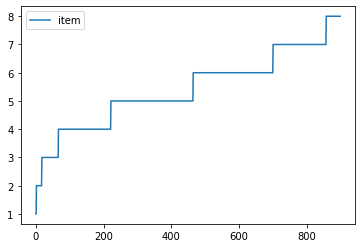

In [10]:
correct_percentage = pd.DataFrame(columns=['item'])
cols = list(df_index)
for i in cols:
  correct_percentage = correct_percentage.append({'item': df_index[i].sum()}, ignore_index=True)

correct_percentage = correct_percentage.drop(correct_percentage.index[[0]])
correct_percentage = correct_percentage.sort_values(by=['item'])
correct_percentage = correct_percentage.reset_index()
correct_percentage.plot(y=['item'])

[Text(0.5, 1.0, '')]

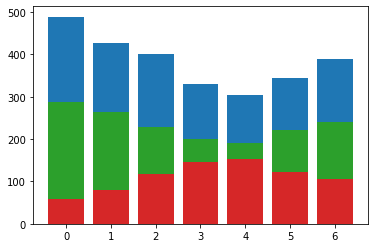

In [59]:
cols = list(df_index)
c2hist = np.zeros(7)
c2hist_diff = np.zeros(7)
c2hist_all_wrong = np.zeros(7)
indices = np.zeros(7)
for i in range(1, 7):
  indices[i] = indices[i - 1] + 1
    
for i in cols:
  for j in range(1, 8):
    if (df_index[i][j] and df_index[i][0]):
      c2hist[j-1] += 1
    if (df_index[i][j] and not df_index[i][0]):
      c2hist_diff[j-1] += 1
    if (not df_index[i][j] and not df_index[i][0]):
      c2hist_all_wrong[j-1] += 1

ax = plt.subplot()
ax.bar(indices,c2hist, color='tab:blue')
ax.bar(indices,c2hist_diff, color='tab:green')
ax.bar(indices,c2hist_all_wrong, color='tab:red')
plt.gca().set( title='')


[Text(0.5, 1.0, '')]

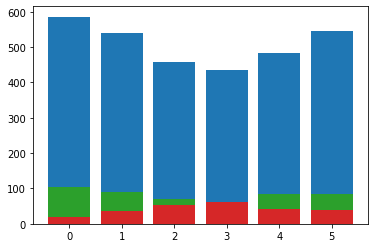

In [64]:
cols = list(df_index)
c4hist = np.zeros(6)
c4hist_diff = np.zeros(6)
c4hist_all_wrong = np.zeros(6)
indices = np.zeros(6)
for i in range(1, 6):
  indices[i] = indices[i - 1] + 1
    
for i in cols:
  for j in range(2, 8):
    if (df_index[i][j] and df_index[i][1]):
      c4hist[j-2] += 1
    if (df_index[i][j] and not df_index[i][1]):
      c4hist_diff[j-2] += 1
    if (not df_index[i][j] and not df_index[i][1]):
      c4hist_all_wrong[j-2] += 1

ax = plt.subplot()
ax.bar(indices,c4hist, color='tab:blue')
ax.bar(indices,c4hist_diff, color='tab:green')
ax.bar(indices,c4hist_all_wrong, color='tab:red')
plt.gca().set( title='')


[Text(0.5, 1.0, '')]

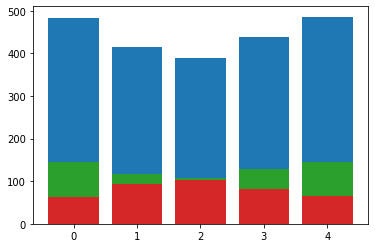

In [65]:
cols = list(df_index)
c8hist = np.zeros(5)
c8hist_diff = np.zeros(5)
c8hist_all_wrong = np.zeros(5)
indices = np.zeros(5)
for i in range(1, 5):
  indices[i] = indices[i - 1] + 1
    
for i in cols:
  for j in range(3, 8):
    if (df_index[i][j] and df_index[i][2]):
      c8hist[j-3] += 1
    if (df_index[i][j] and not df_index[i][2]):
      c8hist_diff[j-3] += 1
    if (not df_index[i][j] and not df_index[i][2]):
      c8hist_all_wrong[j-3] += 1

ax = plt.subplot()
ax.bar(indices,c8hist, color='tab:blue')
ax.bar(indices,c8hist_diff, color='tab:green')
ax.bar(indices,c8hist_all_wrong, color='tab:red')
plt.gca().set( title='')


[Text(0.5, 1.0, '')]

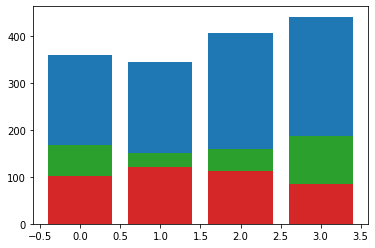

In [66]:
cols = list(df_index)
c16hist = np.zeros(4)
c16hist_diff = np.zeros(4)
c16hist_all_wrong = np.zeros(4)
indices = np.zeros(4)
for i in range(1, 4):
  indices[i] = indices[i - 1] + 1
    
for i in cols:
  for j in range(4, 8):
    if (df_index[i][j] and df_index[i][3]):
      c16hist[j-4] += 1
    if (df_index[i][j] and not df_index[i][3]):
      c16hist_diff[j-4] += 1
    if (not df_index[i][j] and not df_index[i][3]):
      c16hist_all_wrong[j-4] += 1

ax = plt.subplot()
ax.bar(indices,c16hist, color='tab:blue')
ax.bar(indices,c16hist_diff, color='tab:green')
ax.bar(indices,c16hist_all_wrong, color='tab:red')
plt.gca().set( title='')


[Text(0.5, 1.0, '')]

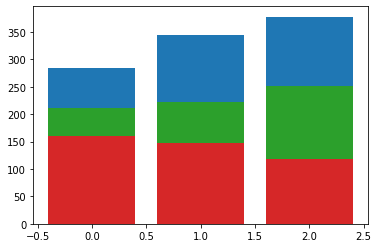

In [67]:
cols = list(df_index)
c30hist = np.zeros(3)
c30hist_diff = np.zeros(3)
c30hist_all_wrong = np.zeros(3)
indices = np.zeros(3)
for i in range(1, 3):
  indices[i] = indices[i - 1] + 1
    
for i in cols:
  for j in range(5, 8):
    if (df_index[i][j] and df_index[i][4]):
      c30hist[j-5] += 1
    if (df_index[i][j] and not df_index[i][4]):
      c30hist_diff[j-5] += 1
    if (not df_index[i][j] and not df_index[i][4]):
      c30hist_all_wrong[j-5] += 1

ax = plt.subplot()
ax.bar(indices,c30hist, color='tab:blue')
ax.bar(indices,c30hist_diff, color='tab:green')
ax.bar(indices,c30hist_all_wrong, color='tab:red')
plt.gca().set( title='')

## Ensemble


In [1]:
import torch, torchvision, torch.nn as nn, torch.optim as optim, torch.nn.functional as F
import torchvision.transforms as transforms, torchvision.models as models
import matplotlib.pyplot as plt
import PIL, IPython
import pathlib
import pandas as pd
import math
import random
from tqdm.auto import tqdm
from collections import OrderedDict
#plt.style.use('dark_background')
import numpy as np


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
device = torch.device('cuda')

In [4]:
dataset_dir = "/content/drive/My Drive/CPEN 291/project/data/"

In [5]:
labels = pd.read_csv(dataset_dir + 'all_labels.csv')

In [6]:
class PriceClassificationDataset:
    def __init__(self, root_dir, num_of_classes, use_random=False, transform=None, transform_label=None):

        root_dir = pathlib.Path(root_dir).resolve()
        self.root_dir = root_dir
        self.transform = transform
        self.transform_label = transform_label

        self.classes = pd.read_csv(root_dir / f'classes_{num_of_classes}.csv')

        if (use_random):
          self.labels_f = pd.read_csv(root_dir / 'all_labels_random.csv')
        else:
          self.labels_f = pd.read_csv(root_dir / 'all_labels.csv')

        def get_class(p):
          if (p >= self.classes['price'][num_of_classes - 1]):
              return num_of_classes - 1
          for i in range(0, len(self.classes['price'])-1):
            if (p >= self.classes['price'][i] and p < self.classes['price'][i + 1]): 
              return i

        def get_price(fn):
            fn = str(fn).rsplit('/', 1)[-1]
            row = self.labels_f.loc[self.labels_f['name'] == fn]
            index = row.index[0]
            return row['price'][index]

        self.fns_labels = [(imgfn, get_class(get_price(imgfn)))
                           for imgfn in sorted(root_dir.glob('*.jpg'))]

    def __len__(self):
        return len(self.fns_labels)

    def __getitem__(self, i):
        if torch.is_tensor(i):
            i = i.item()
        imgfn, label = self.fns_labels[i]
        img = PIL.Image.open(imgfn)
        img = img.convert('RGB')
        if self.transform:
            img = self.transform(img)
        if self.transform_label:
            label = self.transform_label(label)
        return (img, label)

In [7]:
xform = torchvision.transforms.Compose([torchvision.transforms.Resize((224,224)), torchvision.transforms.ToTensor()])
d2 = PriceClassificationDataset(dataset_dir, 2, use_random=False, transform=xform)
d4 = PriceClassificationDataset(dataset_dir, 4, use_random=False, transform=xform)
d8 = PriceClassificationDataset(dataset_dir, 8, use_random=False, transform=xform)
d16 = PriceClassificationDataset(dataset_dir, 16, use_random=False, transform=xform)
d30 = PriceClassificationDataset(dataset_dir, 30, use_random=False, transform=xform)
d50 = PriceClassificationDataset(dataset_dir, 50, use_random=False, transform=xform)
d75 = PriceClassificationDataset(dataset_dir, 75, use_random=False, transform=xform)
d100 = PriceClassificationDataset(dataset_dir, 100, use_random=False, transform=xform)
print(f"""
{len(d2)}, {len(d4)},{len(d8)},{len(d16)},{len(d30)},{len(d50)},{len(d75)},{len(d100)}
""")


4498, 4498,4498,4498,4498,4498,4498,4498



In [8]:
m2 = torchvision.models.resnet34(pretrained=True)
m2.fc = torch.nn.Linear(m2.fc.in_features, len(d2.classes))
m2.to(device);
m4 = torchvision.models.resnet34(pretrained=True)
m4.fc = torch.nn.Linear(m4.fc.in_features, len(d4.classes))
m4.to(device);
m8 = torchvision.models.resnet18(pretrained=True)
m8.fc = torch.nn.Linear(m8.fc.in_features, len(d8.classes))
m8.to(device);
m16 = torchvision.models.resnet18(pretrained=True)
m16.fc = torch.nn.Linear(m16.fc.in_features, len(d16.classes))
m16.to(device);
m30 = torchvision.models.resnet18(pretrained=True)
m30.fc = torch.nn.Linear(m30.fc.in_features, len(d30.classes))
m30.to(device);
m50 = torchvision.models.resnet18(pretrained=True)
m50.fc = torch.nn.Linear(m50.fc.in_features, len(d50.classes))
m50.to(device);
m75 = torchvision.models.resnet34(pretrained=True)
m75.fc = torch.nn.Linear(m75.fc.in_features, len(d75.classes))
m75.to(device);
m100 = torchvision.models.resnet34(pretrained=True)
m100.fc = torch.nn.Linear(m100.fc.in_features, len(d100.classes))
m100.to(device);

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [9]:
m2.load_state_dict(torch.load('/content/drive/My Drive/CPEN 291/project/classification_models/model_jared_3_resnet18_2_wd02_10iter.pth'))
m4.load_state_dict(torch.load('/content/drive/My Drive/CPEN 291/project/classification_models/model_jared_3_resnet18_4_wd02_10iter.pth'))
m8.load_state_dict(torch.load('/content/drive/My Drive/CPEN 291/project/classification_models/model_jared_3_resnet18_8_wd02_10iter.pth'))
m16.load_state_dict(torch.load('/content/drive/My Drive/CPEN 291/project/classification_models/model_jared_3_resnet18_16_wd02_10iter.pth'))
m30.load_state_dict(torch.load('/content/drive/My Drive/CPEN 291/project/classification_models/model_jared_3_resnet18_30_wd02_10iter.pth'))
m50.load_state_dict(torch.load('/content/drive/My Drive/CPEN 291/project/classification_models/model_jared_3_resnet18_50_wd02_10iter.pth'))
m75.load_state_dict(torch.load('/content/drive/My Drive/CPEN 291/project/classification_models/model_jared_3_resnet18_75_wd02_10iter.pth'))
m100.load_state_dict(torch.load('/content/drive/My Drive/CPEN 291/project/classification_models/model_jared_3_resnet34_100_10iter.pth'))

m2.eval()
m4.eval()
m8.eval()
m16.eval()
m30.eval()
m50.eval()
m75.eval()
m100.eval()

<All keys matched successfully>

In [10]:
c2 = pd.read_csv(dataset_dir + 'classes_2.csv')
c4 = pd.read_csv(dataset_dir + 'classes_4.csv')
c8 = pd.read_csv(dataset_dir + 'classes_8.csv')
c16 = pd.read_csv(dataset_dir + 'classes_16.csv')
c30 = pd.read_csv(dataset_dir + 'classes_30.csv')
c50 = pd.read_csv(dataset_dir + 'classes_50.csv')
c75 = pd.read_csv(dataset_dir + 'classes_75.csv')
c100 = pd.read_csv(dataset_dir + 'classes_100.csv')
classes = [c2, c4, c8, c16, c30, c50, c75, c100]
# wrapper class for comparison
# untrainable, only for demo
class wrapper(nn.Module):
    def __init__(self):
        super(wrapper, self).__init__()
        self.m2 = m2
        self.m4 = m4
        self.m8 = m8
        self.m16 = m16
        self.m30 = m30
        self.m50 = m50
        self.m75 = m75
        self.m100 = m100

    def forward(self, x):
        _, p2 = torch.max(self.m2(x).detach(), 1) # pick highest-score class
        _, p4 = torch.max(self.m4(x).detach(), 1) 
        _, p8 = torch.max(self.m8(x).detach(), 1) 
        _, p16 = torch.max(self.m16(x).detach(), 1) 
        _, p30 = torch.max(self.m30(x).detach(), 1) 
        _, p50 = torch.max(self.m50(x).detach(), 1) 
        _, p75 = torch.max(self.m75(x).detach(), 1) 
        _, p100 = torch.max(self.m100(x).detach(), 1) 
        allp = [p2, p4, p8, p16, p30, p50, p75, p100]
        pred = p2
        for i in range(p2.size()[0]): # all of them should have the same size
          with100 = [p100]
          if (p100[i] >= p2[i]/2.0 * 100 and p100[i] <= (p2[i] + 1)/2.0 * 100):
            with100.append(p2)
          if (p100[i] >= p4[i]/4.0 * 100 and p100[i] <= (p4[i] + 1)/4.0 * 100 ):
            with100.append(p4)
          if (p100[i] >= p8[i]/8.0 * 100 and p100[i] <= (p8[i] + 1)/8.0 * 100 ):
            with100.append(p8)
          if (p100[i] >= p16[i]/16.0 * 100 and p100[i] <= (p16[i] + 1)/16.0 * 100 ):
            with100.append(p16)
          if (p100[i] >= p30[i]/30.0 * 100 and p100[i] <= (p30[i] + 1)/30.0 * 100 ):
            with100.append(p30)
          if (p100[i] >= p50[i]/50.0 * 100 and p100[i] <= (p50[i] + 1)/50.0 * 100 ):
            with100.append(p50)
          if (p100[i] >= p75[i]/75.0 * 100 and p100[i] <= (p75[i] + 1)/75.0 * 100 ):
            with100.append(p75)
          with75 = [p75]
          if (p75[i] >= p2[i]/2.0 * 75 and p75[i] <= (p2[i] + 1)/2.0 * 75):
            with75.append(p2)
          if (p75[i] >= p4[i]/4.0 * 75 and p75[i] <= (p4[i] + 1)/4.0 * 75 ):
            with75.append(p4)
          if (p75[i] >= p8[i]/8.0 * 75 and p75[i] <= (p8[i] + 1)/8.0 * 75 ):
            with75.append(p8)
          if (p75[i] >= p16[i]/16.0 * 75 and p75[i] <= (p16[i] + 1)/16.0 * 75 ):
            with75.append(p16)
          if (p75[i] >= p30[i]/30.0 * 75 and p75[i] <= (p30[i] + 1)/30.0 * 75 ):
            with75.append(p30)
          if (p75[i] >= p50[i]/50.0 * 75 and p75[i] <= (p50[i] + 1)/50.0 * 75 ):
            with75.append(p50)
          with50 = [p50]
          if (p50[i] >= p2[i]/2.0 * 50 and p50[i] <= (p2[i] + 1)/2.0 * 50):
            with50.append(p2)
          if (p50[i] >= p4[i]/4.0 * 50 and p50[i] <= (p4[i] + 1)/4.0 * 50 ):
            with50.append(p4)
          if (p50[i] >= p8[i]/8.0 * 50 and p50[i] <= (p8[i] + 1)/8.0 * 50 ):
            with50.append(p8)
          if (p50[i] >= p16[i]/16.0 * 50 and p50[i] <= (p16[i] + 1)/16.0 * 50 ):
            with50.append(p16)
          if (p50[i] >= p30[i]/30.0 * 50 and p50[i] <= (p30[i] + 1)/30.0 * 50 ):
            with50.append(p30)
          with30 = [p30]
          if (p30[i] >= p2[i]/2.0 * 30 and p30[i] <= (p2[i] + 1)/2.0 * 30):
            with30.append(p2)
          if (p30[i] >= p4[i]/4.0 * 30 and p30[i] <= (p4[i] + 1)/4.0 * 30 ):
            with30.append(p4)
          if (p30[i] >= p8[i]/8.0 * 30 and p30[i] <= (p8[i] + 1)/8.0 * 30 ):
            with30.append(p8)
          if (p30[i] >= p16[i]/16.0 * 30 and p30[i] <= (p16[i] + 1)/16.0 * 30 ):
            with30.append(p16)
          with16 = [p16]
          if (p16[i] >= p2[i]/2.0 * 16 and p16[i] <= (p2[i] + 1)/2.0 * 16):
            with16.append(p2)
          if (p16[i] >= p4[i]/4.0 * 16 and p16[i] <= (p4[i] + 1)/4.0 * 16 ):
            with16.append(p4)
          if (p16[i] >= p8[i]/8.0 * 16 and p16[i] <= (p8[i] + 1)/8.0 * 16 ):
            with16.append(p8)
          with8 = [p8]
          if (p8[i] >= p2[i]/2.0 * 8 and p8[i] <= (p2[i] + 1)/2.0 * 8):
            with8.append(p2)
          if (p8[i] >= p4[i]/4.0 * 8 and p8[i] <= (p4[i] + 1)/4.0 * 8 ):
            with8.append(p4)
          with4 = [p4]
          if (p4[i] >= p4[i]/2.0 * 4 and p4[i] <= (p2[i] + 1)/2.0 * 4):
            with4.append(p2)


          df = pd.DataFrame(columns=['model', 'length'])
          df = df.append({'model': 7, 'length': len(with100)}, ignore_index=True)
          df = df.append({'model': 6, 'length': len(with75)}, ignore_index=True)
          df = df.append({'model': 5, 'length': len(with50)}, ignore_index=True)
          df = df.append({'model': 4, 'length': len(with30)}, ignore_index=True)
          df = df.append({'model': 3, 'length': len(with16)}, ignore_index=True)
          df = df.append({'model': 2, 'length': len(with8)}, ignore_index=True)
          df = df.append({'model': 1, 'length': len(with4)}, ignore_index=True)

          df = df.sort_values(by=['length', 'model'])
          df = df.reset_index()
          row_1=df.iloc[0]
          ind = row_1['model']
          if (allp[ind][i].item() < len(classes[ind]) - 1):
            pred[i] = math.log(classes[ind]['price'][allp[ind][i].item()] + (classes[ind]['price'][allp[ind][i].item()+1] - classes[ind]['price'][allp[ind][i].item()]) * (1/2.0))
          else:
            pred[i] = math.log(classes[ind]['price'][allp[ind][i].item()] + (20000 - classes[ind]['price'][allp[ind][i].item()]) * (1/2.0))
            
        return pred.unsqueeze(1)

def run_test_2(model, criterion, no_preds=False):
    nsamples_test = len(dataset_test2)
    loss = 0
    preds = []
    model.eval()
    with torch.no_grad():
        for samples, labels in loader_test2:
            samples = samples.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            outs = model(samples)
            if not no_preds:
                preds += outs.cpu().unbind()
            loss += criterion(outs, labels) * samples.size(0)
    return loss / nsamples_test, preds

In [11]:
# Modified from object_detection.ipynb
class PricePredictionDataset:
    def __init__(self, root_dir, use_random=False, transform=None, transform_label=None):
        root_dir = pathlib.Path(root_dir).resolve()
        self.root_dir = root_dir
        self.transform = transform
        self.transform_label = transform_label

        if (use_random):
          self.labels_f = pd.read_csv(root_dir / 'all_labels_random.csv')
        else:
          self.labels_f = pd.read_csv(root_dir / 'all_labels.csv')

        def get_price(fn):
            fn = str(fn).rsplit('/', 1)[-1]
            row = self.labels_f.loc[self.labels_f['name'] == fn]
            index = row.index[0]
            return math.log(row['price'][index]) # log because we are scientists

        self.fns_labels = [(imgfn, get_price(imgfn))
                           for imgfn in sorted(root_dir.glob('*.jpg'))]

    def __len__(self):
        return len(self.fns_labels)

    def __getitem__(self, i):
        if torch.is_tensor(i):
            i = i.item()
        imgfn, label = self.fns_labels[i]
        img = PIL.Image.open(imgfn)
        if (len(img.split()) > 3): # some images have one more channel
          r,g,b, _ = img.split()
          img = PIL.Image.merge('RGB', (r,g,b))
        if (len(img.split()) == 1): # some images only have one channel
          img = img.convert('RGB')
        if self.transform:
            img = self.transform(img)
        if self.transform_label:
            label = self.transform_label(label)
        return (img, label)

In [12]:
dataset_full2= PricePredictionDataset(dataset_dir, False, transform=xform)

In [13]:
n_all= len(dataset_full2)
n_used= int(1 * n_all)
n_train= int(0.8 * n_used)
n_test= n_used- n_train
rng= torch.Generator().manual_seed(291)
dataset_train2, dataset_test2, _ = torch.utils.data.random_split(dataset_full2, [n_train, n_test, n_all-n_train-n_test], rng)
len(dataset_train2), len(dataset_test2)

(3598, 900)

In [14]:
loader_train2 = torch.utils.data.DataLoader(dataset_train2, batch_size=32, shuffle=False)
loader_test2 = torch.utils.data.DataLoader(dataset_test2, batch_size=32, shuffle=False)

In [15]:
criterion2 = torch.nn.MSELoss()

In [16]:
w = wrapper()
test_loss, test_preds= run_test_2(w, criterion2)
print(test_loss)

tensor(0.9598, device='cuda:0')


In [17]:
test_loss

tensor(0.9598, device='cuda:0')

In [18]:
# Modified from object_detection.ipynb
def show_img_price2(sample):
    img, price = sample
    if torch.is_tensor(img):
        img = img.cpu().permute(1,2,0)
    plt.imshow(img)
    plt.title(math.e**price, color='black') # add color='w' arg if using a dark background
    plt.axis('off')

Prediction     | Real Price


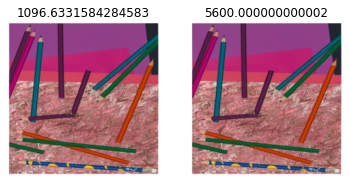

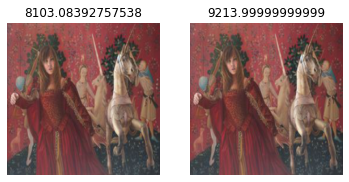

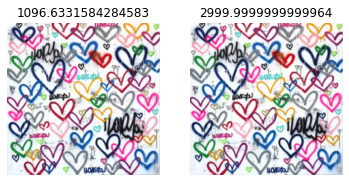

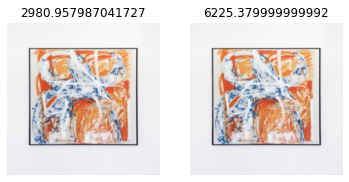

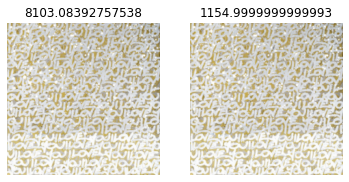

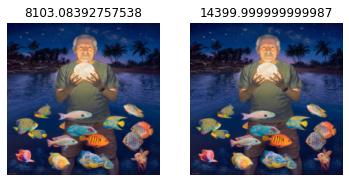

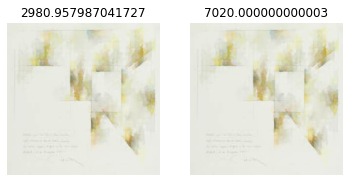

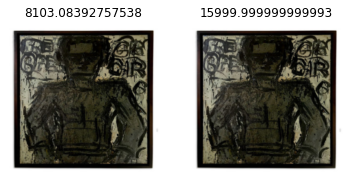

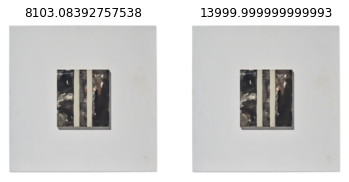

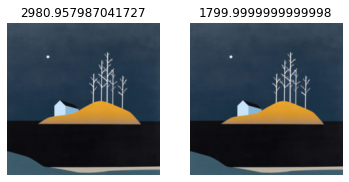

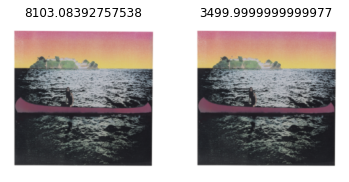

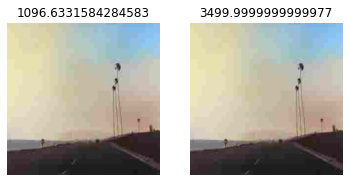

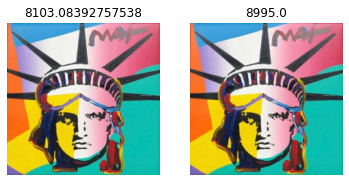

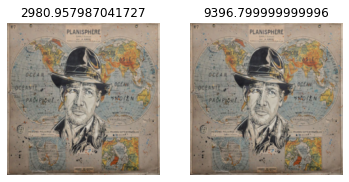

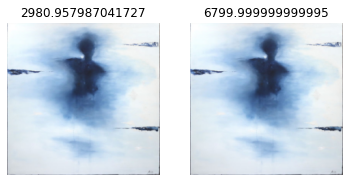

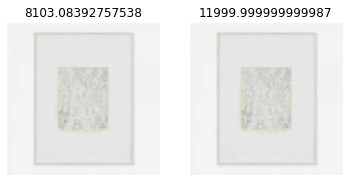

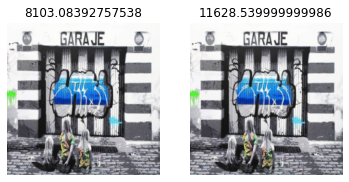

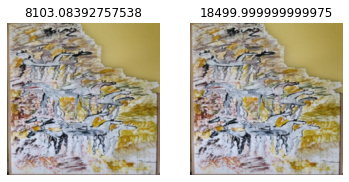

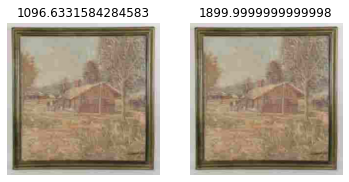

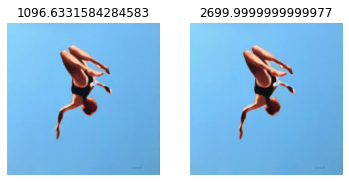

In [19]:
print("Prediction     | Real Price")
for i in range(20):
    f = plt.figure()
    f.add_subplot(1,2, 1)
    show_img_price2((dataset_test2[i][0], test_preds[i].item()))
    f.add_subplot(1,2, 2)
    show_img_price2(dataset_test2[i])
    plt.show(block=True)
